In [303]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

1. Global methane levels from 2002

In [304]:
ds= xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xch4                     (time, lat, lon) float32 ...
    xch4_nobs                (time, lat, lon) float64 ...
    xch4_stderr              (time, lat, lon) float32 ...
    xch4_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_ch4_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2021-02-05T09:48:47Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.3
    title:                  C3S XCH4 v4.3
    tracking_id:            892d184a-7b35-4bba-836a-94b9cfeb360e
    variable_id:            xch4
    variant_info:           Best Estimate
    variant_label:          BE

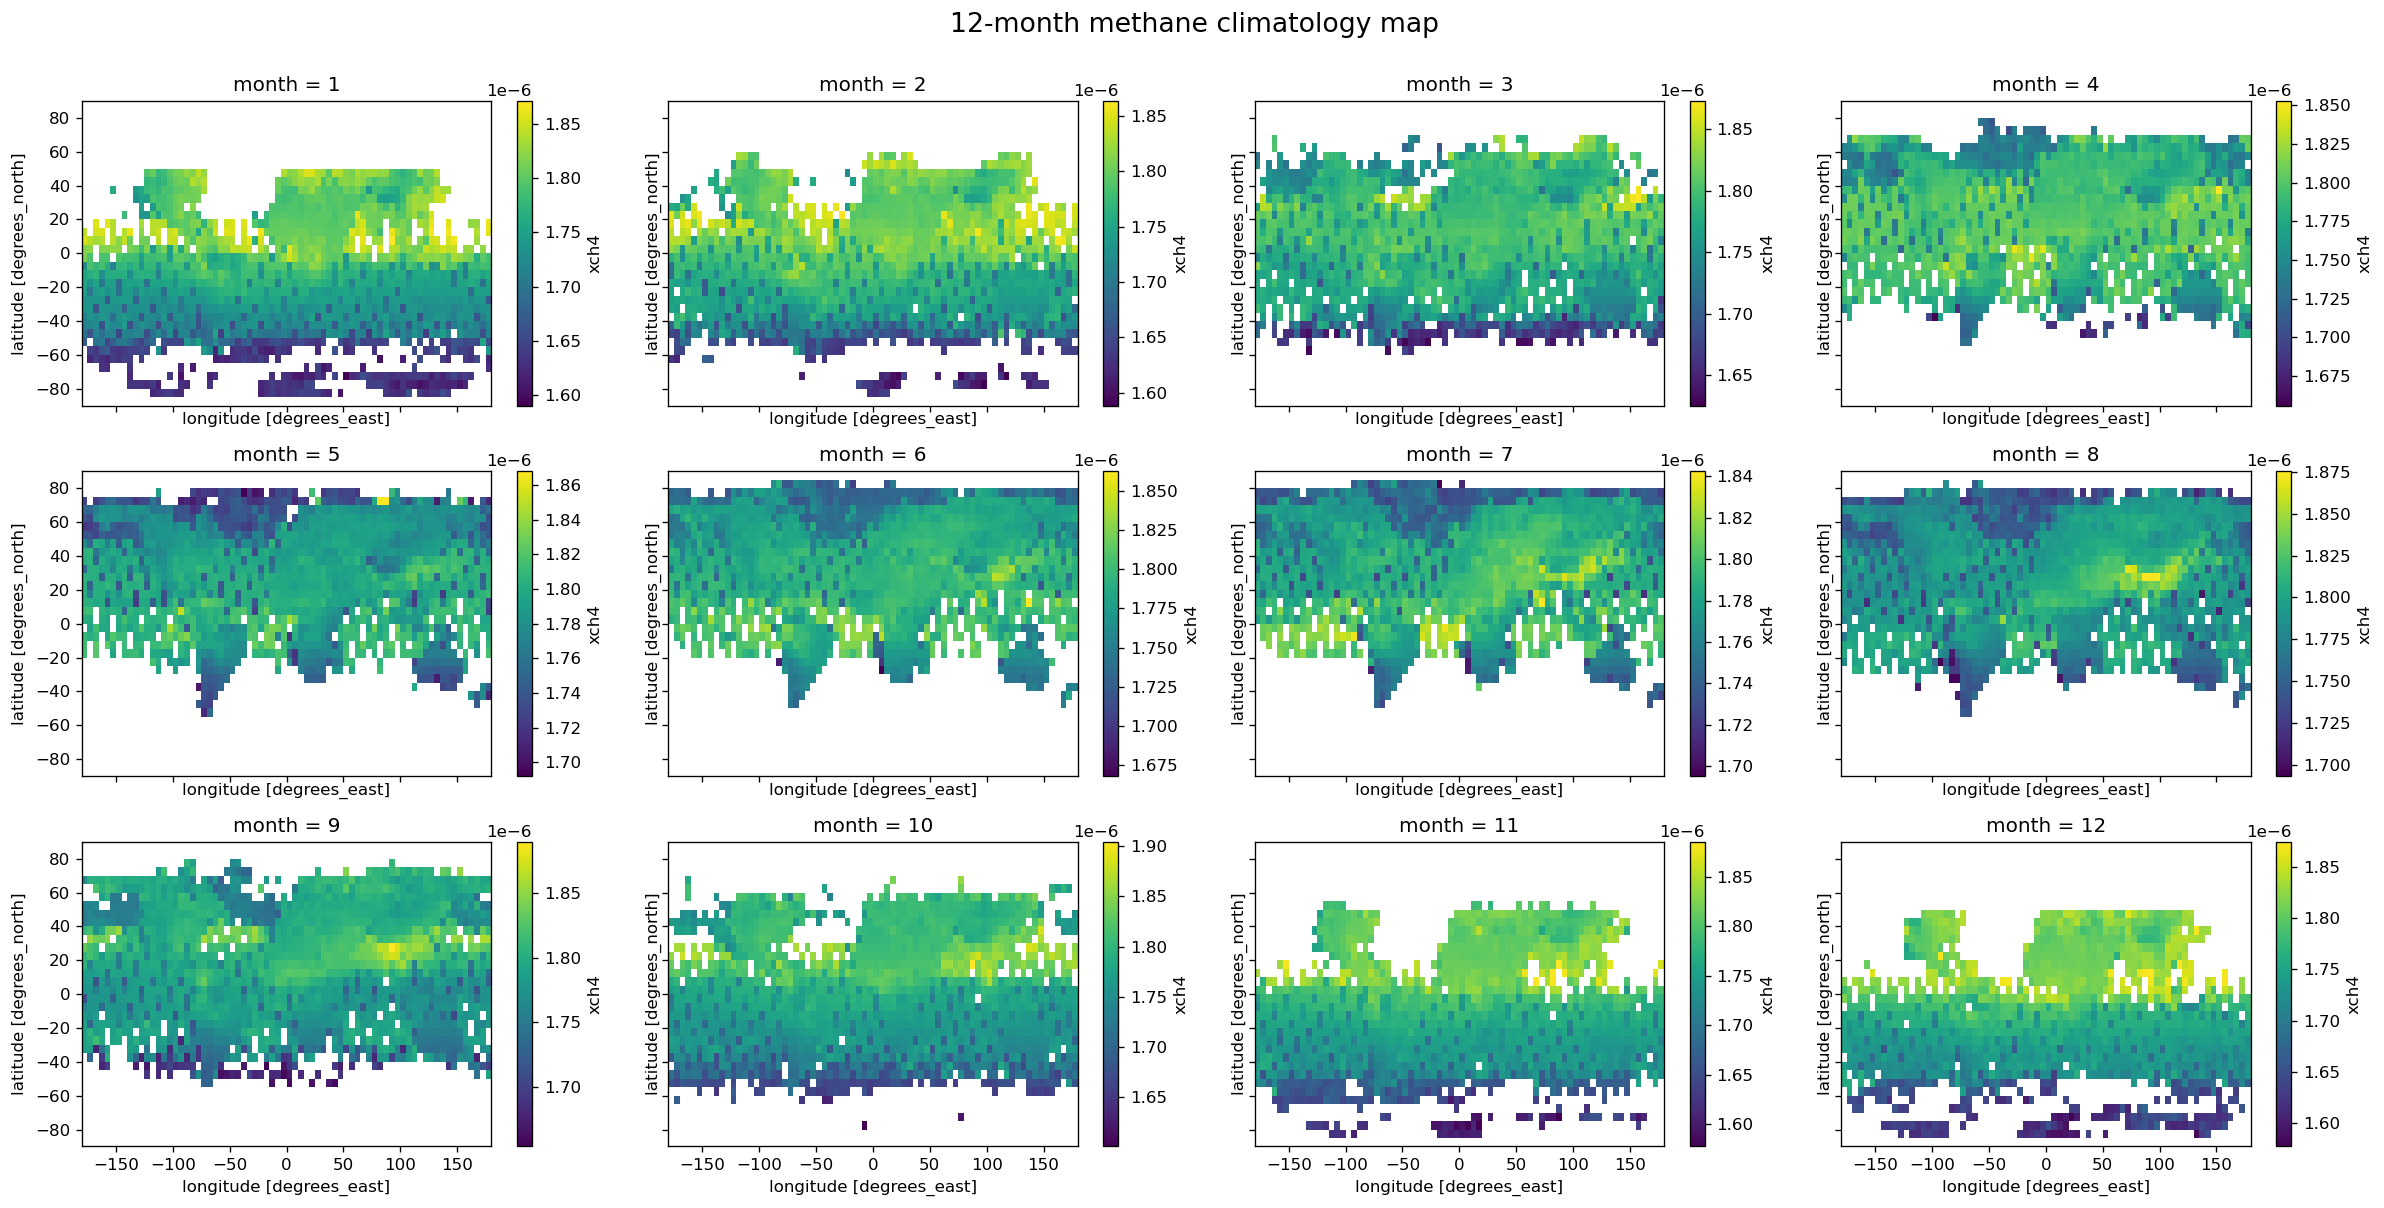

In [306]:
#1.1
#创建12个axes，3行4列，共享x、y轴，分辨率120
fig, axes = plt.subplots(3,4, figsize=(20,10), sharex=True, sharey=True, dpi=120)

#将数组axes拉成一维数组
axes=axes.ravel()
xch4_month=ds.xch4.groupby('time.month').mean()

#将1~12月的数据放入每个对应的axes中
for i in range(12):
    axes[i]=plt.subplot(3,4,i+1) 
    xch4_month[i,:,:].plot() 
    
plt.suptitle('12-month methane climatology map', verticalalignment='bottom', fontsize=16)   
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Time series diagram of global mean methane')

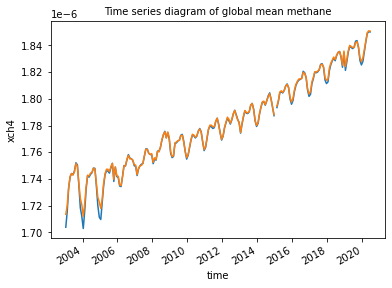

In [307]:
#1.2
#先按月分组，再求全球平均xch4，作图
ds.xch4.groupby('time.month').mean(dim=['lat','lon']).plot()

#考虑纬度权重
weights = np.cos(np.deg2rad(ds.lat))
ds.xch4.weighted(weights).mean(dim=['lat', 'lon']).plot()

plt.title('Time series diagram of global mean methane', fontsize=10) 

#蓝色为纬度权重前的图，黄色为纬度权重后的图
#全球平均甲烷含量逐年增加，自2003-01到2020-06，甲烷大致增加0.12*10^-6。全球甲烷含量有一定的季节性。

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Text(0.5, 1.0, 'Deseasonalized methane levels at point [15°S, 150°W]')

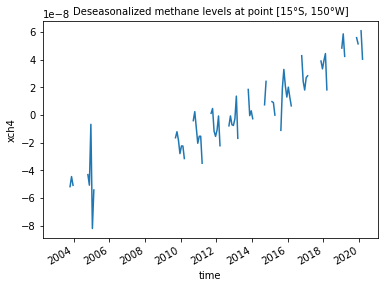

In [309]:
#1.3
#西经为负数，南纬为负数
#求异常值
xch4_anom = ds.xch4.groupby('time.month') - ds.xch4.groupby('time.month').mean()

#画[15°S, 150°W]的xch4月异常值图
xch4_anom.sel(lon=-150,lat=-15,method='nearest').plot()

plt.title('Deseasonalized methane levels at point [15°S, 150°W]', fontsize=10) 

2. Niño 3.4 index

In [61]:
ds_2= xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
ds_2

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [310]:
#2.1
#西经为180°-360°，例如西经170°转化为360°格式应为180+|180-170|=190;南纬为负数
sst = ds_2.sst.sel(lat=slice(-5,5),lon=slice(-170+360,-120+360))
sst.groupby("time.month")

#求异常值
sst_anom = sst.groupby("time.month")-sst.groupby('time.month').mean()
#3个月滚动平均
sst_anom_rolling = sst_anom.rolling(time=3, center=True).mean()

#考虑权重，并应用到异常值的3个月滚动平均上
weights = np.cos(np.deg2rad(ds_2.lat)) 
weighted_sst_anom_rolling=sst_anom_rolling.weighted(weights).mean(dim=['lat', 'lon'])
weighted_sst_anom_rolling

<xarray.DataArray 'sst' (time: 684)>
array([            nan, -3.52136731e-01, -3.07922482e-01, -2.10942671e-01,
       -2.40801468e-01, -2.25801334e-01, -1.61719128e-01, -9.32449624e-02,
       -1.72556192e-01, -2.97744423e-01, -3.16537887e-01, -2.53706843e-01,
       -1.78142399e-01, -1.88687652e-01, -1.86583191e-01, -1.24505967e-01,
        3.54308113e-02,  7.37191290e-02, -8.31784979e-02, -4.22465146e-01,
       -6.63186014e-01, -6.89041138e-01, -5.68683267e-01, -4.52810347e-01,
       -4.39396203e-01, -4.45670635e-01, -4.53058064e-01, -4.89248693e-01,
       -4.86178070e-01, -4.22765821e-01, -3.40314269e-01, -4.22423422e-01,
       -5.52226961e-01, -7.19083309e-01, -7.83191741e-01, -7.94970274e-01,
       -6.41396105e-01, -3.29650164e-01, -3.80033664e-02,  5.07872105e-02,
        5.31975366e-02,  2.24640876e-01,  5.20021141e-01,  7.32085824e-01,
        7.80955553e-01,  8.18719685e-01,  9.43071008e-01,  9.48859394e-01,
        8.20473313e-01,  4.14922297e-01, -8.05010572e-02, -5.42425752e-01,
       -8.14303160e-01, -8.64234805e-01, -9.41662908e-01, -1.04450929e+00,
       -1.17973232e+00, -1.24559689e+00, -1.22900093e+00, -1.09335089e+00,
       -7.85555542e-01, -4.21444982e-01, -1.85970977e-01,  2.64181197e-02,
        2.61038065e-01,  5.57310939e-01,  8.80600035e-01,  1.10944867e+00,
        1.34691095e+00,  1.46194518e+00,  1.51645255e+00,  1.40029490e+00,
        1.17677569e+00,  1.02102411e+00,  8.11687589e-01,  4.64973003e-01,
        1.96538165e-01,  8.31781104e-02,  6.70664907e-02, -7.60612562e-02,
...
       -1.36074400e+00, -1.42106140e+00, -1.39463878e+00, -1.40015888e+00,
       -1.29396772e+00, -1.12907672e+00, -8.00107419e-01, -4.95390236e-01,
       -1.95580482e-01, -7.08500594e-02, -1.23495981e-01, -3.31612468e-01,
       -5.43040037e-01, -7.75044441e-01, -9.15336668e-01, -9.00234044e-01,
       -7.56594241e-01, -5.23062527e-01, -3.40005398e-01, -1.79401472e-01,
       -5.35799488e-02,  5.45777306e-02,  2.09617987e-01,  4.63171124e-01,
        6.14919424e-01,  6.54052317e-01,  2.47407541e-01, -1.93741620e-01,
       -5.42838812e-01, -5.37602305e-01, -2.73900002e-01, -1.03897184e-01,
       -5.97274527e-02, -1.80382788e-01, -2.66270399e-01, -2.59501129e-01,
       -1.97798893e-01, -1.51537657e-01, -2.10540935e-01, -3.62733006e-01,
       -5.33842206e-01, -5.30328214e-01, -3.43480617e-01,  1.85666047e-03,
        1.98382467e-01,  2.20249832e-01,  9.81423333e-02,  1.13650247e-01,
        2.57235050e-01,  5.44631302e-01,  7.00885713e-01,  7.35688686e-01,
        6.30334258e-01,  5.86936116e-01,  6.80796325e-01,  8.34041774e-01,
        1.01719224e+00,  1.18371272e+00,  1.40097487e+00,  1.65836024e+00,
        1.96497190e+00,  2.31396699e+00,  2.51632094e+00,  2.56233978e+00,
        2.37583923e+00,  2.07454562e+00,  1.63750851e+00,  1.07777739e+00,
        5.00900269e-01, -7.20153004e-02, -4.42695677e-01, -6.18627191e-01,
       -7.28377819e-01, -8.36066544e-01, -9.07837391e-01,             nan],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [311]:
#2.2
#新建一个datafram，设置anom>=0、anom<0列，并将date设置为索引
df = pd.DataFrame(weighted_sst_anom_rolling.where(weighted_sst_anom_rolling>=0),columns=['anom>=0'])
df['anom<0']=pd.DataFrame(weighted_sst_anom_rolling.where(weighted_sst_anom_rolling<0))
df['date'] = pd.DataFrame(weighted_sst_anom_rolling.time)
df.set_index('date', inplace = True)
df

,anom>=0,anom<0
date,,
1960-01-15,NaN,NaN
1960-02-15,NaN,-0.352137
1960-03-15,NaN,-0.307922
1960-04-15,NaN,-0.210943
1960-05-15,NaN,-0.240801
...,...,...
2016-08-15,NaN,-0.618627
2016-09-15,NaN,-0.728378
2016-10-15,NaN,-0.836067


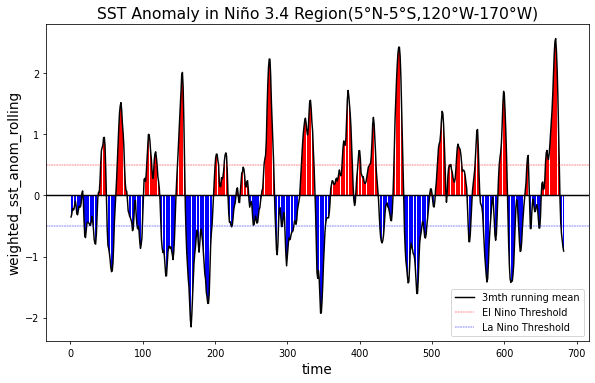

In [312]:
#2.2-续
plt.figure(figsize=(10,6), dpi=70) 
#根据anom>=0、anom<0两列作条形图，非负数异常值，用红色表示，负数异常值，用蓝色表示
plt.bar(np.arange(len(df['anom>=0'])),df['anom>=0'],color ="red")
plt.bar(np.arange(len(df['anom<0'])),df['anom<0'],color ="blue")

#作3个月滚动平均异常值点线图
plt.plot(weighted_sst_anom_rolling,'k-')
#作y=0.5、0、-0.5，三条线，并设置图例
plt.axhline(y=0.5,color ="red", linestyle ="--",linewidth=0.5)
plt.axhline(y=-0.5,color ="blue", linestyle ="--",linewidth=0.5)
plt.axhline(y=0,color ="black", linestyle ="-",linewidth=1.5)
plt.legend(labels=['3mth running mean','El Nino Threshold','La Nino Threshold'],loc=4)

plt.ylabel('weighted_sst_anom_rolling',fontsize=14)
plt.xlabel('time',fontsize=14)
plt.title('SST Anomaly in Niño 3.4 Region(5°N-5°S,120°W-170°W)',fontsize=16)

plt.show()

3. Explore a netCDF dataset

In [218]:
ds_3= xr.open_dataset("CESM2_200001-201412.nc", engine="netcdf4")
ds_3

#因为在网站上下载不了keyword：ozone的netCDF格式文件，所以用了之前Section 07课堂上的文件

C:\ProgramData\Anaconda3\lib\site-packages\xarray\conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 180, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/a7278f6d-6a1b-4050-8f06-a8033604736a
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

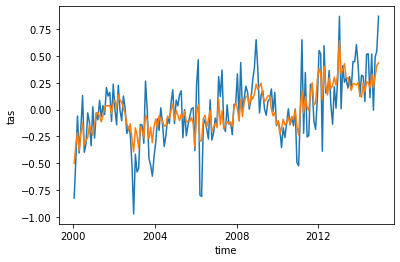

In [313]:
#3.1
#作tas全球月异常值点线图
tas_anom = ds_3.tas.groupby('time.month') - ds_3.tas.groupby('time.month').mean()
tas_anom.mean(dim=['lat', 'lon']).plot()

#考虑权重后画tas全球月异常值点线图
weights = np.cos(np.deg2rad(ds_3.lat)) 
weighted_tas_anom=tas_anom.weighted(weights)
weighted_tas_anom.mean(dim=['lat', 'lon']).plot()

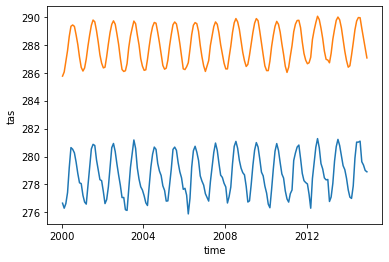

In [314]:
#3.2(1)
#Plot a time series of global monthly mean tas from 2000-01 to 2014-12
ds_3.tas.sel(time=slice("2000-01", "2014-12")).groupby('time.month').mean(dim=['lat', 'lon']).plot()

#考虑权重
weights = np.cos(np.deg2rad(ds_3.lat))
ds_3.tas.weighted(weights).mean(dim=['lat', 'lon']).plot()

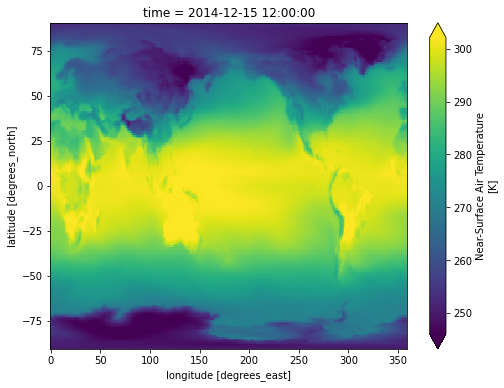

In [267]:
#3.2(2)
#作2014年12月全球月近表温度（tas）的2维图
ds_3.tas.isel(time=-1).plot(robust=True, figsize=(8,6))

#Plot the averaged global tas at December
#tas_clim = ds_3.tas.groupby('time.month').mean()
#tas_clim[11,:,:].plot(vmin=250, vmax=300,figsize=(8,6))

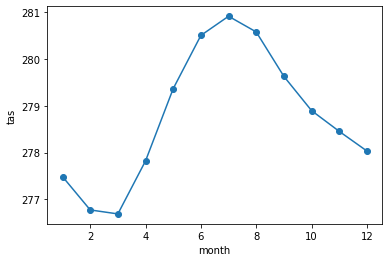

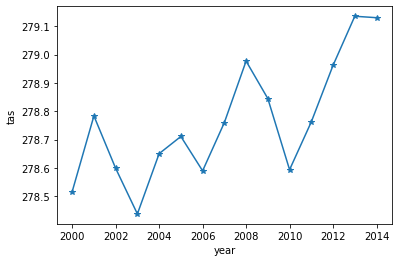

In [292]:
#3.2(3)
# 全球tas月变化趋势图，6-8月是全球高温期
ds_3.tas.groupby('time.month').mean().mean(dim=['lat', 'lon']).plot(marker="o", size=4)

# 全球tas年变化趋势图，温度逐年波动升高
ds_3.tas.groupby('time.year').mean().mean(dim=['lat', 'lon']).plot(marker="*", size=4)

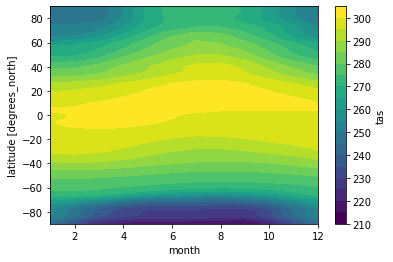

In [295]:
#3.2(4)
#绘制不同纬度平均气候学等高线图
ds_3.tas.groupby('time.month').mean().mean(dim='lon').transpose().plot.contourf(levels=20, robust=False, cmap='viridis')

In [300]:
#3.2(5)
#Draw an interactive plot
import hvplot.xarray
ds_3.tas.hvplot()

:NdOverlay   [Element]
   :Histogram   [tas]   (tas_count)

In [315]:
#3.2(6)
#作2014年12月全球近表温度（tas）的interactive plot
ds_3.tas.isel(time=-1).hvplot(cmap="fire")

:Image   [lon,lat]   (tas)